In [39]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import cv2
import csv
from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from keras.layers.normalization import batch_normalization
import os
import seaborn as sns
from datetime import datetime

In [40]:
# Set up folder
SIZE = 128 #Size of the images this model will deal with
Filters = 32

In [41]:
# Set up folder, unless it is already set up
p = os.path.abspath('.')
output_dir = os.path.join(p, f'{SIZE}')
if not os.path.exists(output_dir):
    os.mkdir(output_dir)
    print(f"{output_dir} created")
else:
    print(f"{output_dir} already exists")
output_dir = output_dir

# Resize images and write them into folder, unless they are alrady there
for file in glob.glob('./Thresholded/*'):
	filename = file.split('/')[-1]
	new_name = os.path.join(output_dir, filename)
	if not os.path.exists(new_name):
		img = cv2.imread(file, cv2.IMREAD_COLOR)
		img = cv2.resize(img, (SIZE,SIZE))
		cv2.imwrite(new_name, img)

# Read filenames in the folder
image_names = []
labels = []

for file in glob.glob(f'{output_dir}/*.jpg'):
	filename = file.split('/')[-1]
	num_colonies = int(filename.split('-')[2].strip().split('.')[0])
	if num_colonies == 0:
		labels.append(0)
	else:
		labels.append(1)
	image_names.append(filename)

image_names = np.array(image_names) #  Array with image nbames
labels = np.array(labels)			#  Array with binary labels

#  Make two arrays with filenames: one for positive and one for negative images
pos_im_files = [image_names[i] for i in range(image_names.shape[0]) if labels[i]]
pos_im_files = np.array(pos_im_files)
neg_im_files = [image_names[i] for i in range(image_names.shape[0]) if not labels[i]]
neg_im_files = np.array(neg_im_files)
num_pos = pos_im_files.shape[0]
num_neg = neg_im_files.shape[0]
print(f'Full dataset: {num_pos} images with bacteria and {num_neg} without')

#  There are ~10x positive than negative.
#  For initital training let's get all positive and equal number of negative
#  For that:
#  (1) Index files of randomly selected negative images
np.random.seed(0) # For reproducibility
idx = np.random.choice(np.arange(neg_im_files.shape[0]), num_pos, replace = False)
#  (2) Apply this index to the array of image names
neg_selected_files = neg_im_files[idx]
#  (3) Make a full set of file names, with X and y, not split into train.test yet
X_files = np.concatenate((pos_im_files,neg_selected_files), axis =0)
y = np.concatenate((np.ones(num_pos), np.zeros(neg_selected_files.shape[0])))

print(f"Balanced dataset: X: {X_files.shape}, y: {y.shape}")

/home/art_usr/source_code/CFU_counter/128 already exists
Full dataset: 315 images with bacteria and 3428 without
Balanced dataset: X: (630,), y: (630,)


In [42]:
# Now shuffle the names
print("Suffling the dataset ....")
num_datapoints = X_files.shape[0]
indices = np.arange(num_datapoints)
shuffled_indices = np.random.permutation(indices)
X_shuffled_files = X_files[shuffled_indices]
y_shuffled = y[shuffled_indices]

# Read the actual files:
print("Reading actual images...")
images = []
for file_name in X_shuffled_files:
    file = os.path.join(output_dir, file_name)
    img = cv2.imread(file, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    images.append(img)

X_shuffled = np.array(images) # Shuffled dataset

# Split into test and train. 
# Rely on random shuffling, can just take first 70% for train
print("Splitting to train/test 70/30")
num_train = int(num_datapoints*0.7)

x_train = X_shuffled[ :num_train, : , : , : ]
y_train = y_shuffled[ :num_train]
x_test = X_shuffled[num_train: , : , : , : ]
y_test = y_shuffled[num_train: ]

print(f'Set shape: train-> {x_train.shape}, test ->{x_test.shape}')

Suffling the dataset ....
Reading actual images...
Splitting to train/test 70/30
Set shape: train-> (441, 128, 128, 3), test ->(189, 128, 128, 3)


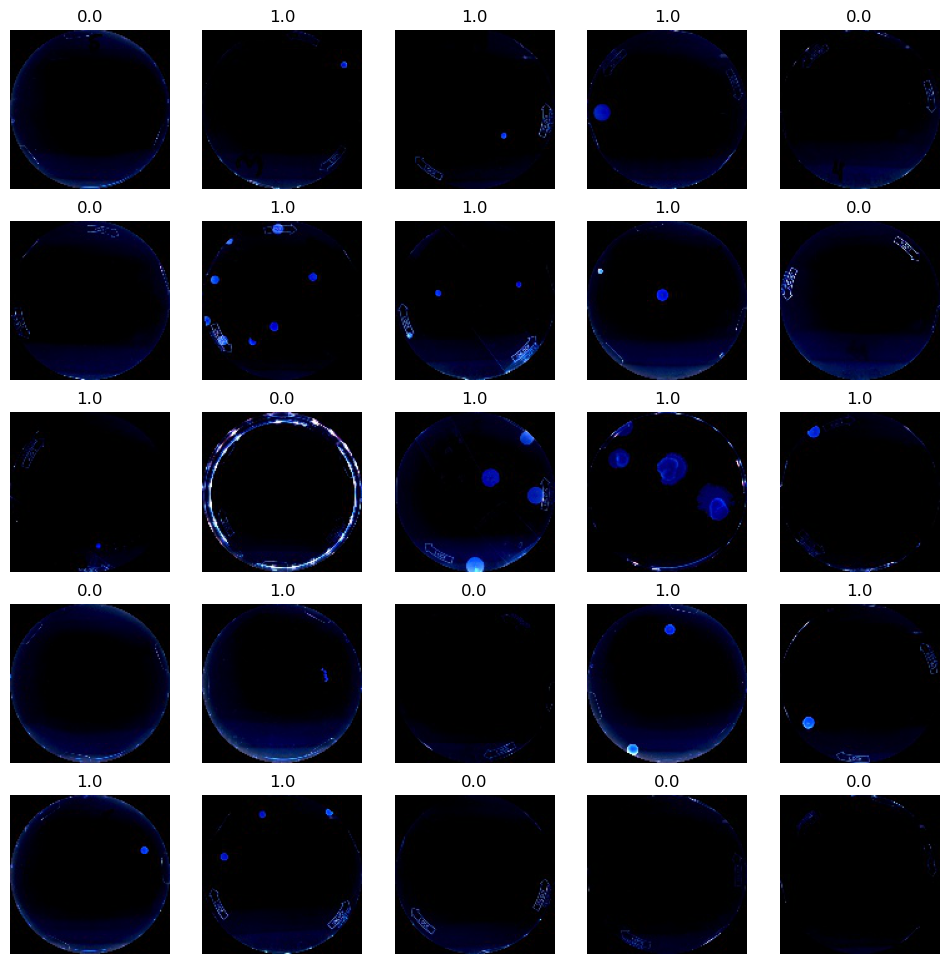

In [43]:
# Visualize first 25 images to make sure it makes sense
fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(12,12))

row = 0
label_name = "Shirt predicted as coat"
axs[row,0].set_title(label_name)
axs[row,0].axis('off')

for i, j in [(i,j) for i in np.arange(5) for j in np.arange(5)]:
    idx = 5*i+j
    image = cv2.cvtColor(x_train[idx], cv2.COLOR_HSV2RGB)
    axs[i,j].imshow(image)
    axs[i,j].set_title(y_train[idx])
    axs[i,j].axis('off')

plt.show()

In [44]:
#Make convolutional layers

kernels = [ (np.max([int(SIZE*fraction), 3]),np.max([int(SIZE*fraction), 3])) for fraction in (0.01, 0.02, 0.04, 0.06)]

activation = 'sigmoid'

feature_extractor = Sequential()
feature_extractor.add(Conv2D(Filters , kernels[0], activation = activation, padding = 'same', input_shape = (SIZE, SIZE, 3)))
feature_extractor.add(batch_normalization.BatchNormalization())

for kernel in kernels[1:]:
    print(kernel)
    feature_extractor.add(Conv2D(Filters , kernel, activation = activation, padding = 'same', kernel_initializer = 'he_uniform'))
    feature_extractor.add(batch_normalization.BatchNormalization())
    feature_extractor.add(MaxPooling2D())

feature_extractor.add(Flatten())

#Add layers for deep learning prediction
x = feature_extractor.output  
x = Dense(128, activation = activation, kernel_initializer = 'he_uniform')(x)
prediction_layer = Dense(2, activation = 'softmax')(x)

# Make a new model combining both feature extractor and x
cnn_model = Model(inputs=feature_extractor.input, outputs=prediction_layer)
cnn_model.compile(optimizer='rmsprop',loss = 'categorical_crossentropy', metrics = ['accuracy'])
print(cnn_model.summary()) 

(3, 3)
(5, 5)
(7, 7)
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8_input (InputLayer)  [(None, 128, 128, 3)]    0         
                                                                 
 conv2d_8 (Conv2D)           (None, 128, 128, 32)      896       
                                                                 
 batch_normalization_8 (Batc  (None, 128, 128, 32)     128       
 hNormalization)                                                 
                                                                 
 conv2d_9 (Conv2D)           (None, 128, 128, 32)      9248      
                                                                 
 batch_normalization_9 (Batc  (None, 128, 128, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 6

In [45]:
from tensorflow.keras.callbacks import Callback

class EarlyStoppingAtAccuracy(Callback):
    def __init__(self, threshold, acc_hist):
        super(EarlyStoppingAtAccuracy, self).__init__()
        self.threshold = threshold
        self.acc_hist = acc_hist

    def on_epoch_end(self, epoch, logs=None):
        val_accuracy = logs.get("val_accuracy")
        self.acc_hist.append(val_accuracy)
        if len(self.acc_hist) > 3 and np.median(self.acc_hist[-3:]) >= self.threshold:
            self.model.stop_training = True
            print(f"\nStopping training: Validation accuracy reached {self.threshold:.2f}")

# Set the desired accuracy threshold
accuracy_threshold = 0.7
acc_hist = []

# Create the early stopping callback
early_stopping = EarlyStoppingAtAccuracy(accuracy_threshold, acc_hist )


#Convert y to one hot encoding for use in CNN 
from keras.utils import to_categorical
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

# Train CNN model
history = cnn_model.fit(x_train, y_train_one_hot, epochs=100, validation_data = (x_test, y_test_one_hot), callbacks=[early_stopping])

Epoch 1/100
14/14 [==============================] - 40s 3s/step - loss: 0.9923 - accuracy: 0.5374 - val_loss: 0.7797 - val_accuracy: 0.4550
Epoch 2/100
14/14 [==============================] - 38s 3s/step - loss: 0.6650 - accuracy: 0.6100 - val_loss: 0.8395 - val_accuracy: 0.4550
Epoch 3/100
14/14 [==============================] - 37s 3s/step - loss: 0.6667 - accuracy: 0.6190 - val_loss: 0.8698 - val_accuracy: 0.4550
Epoch 4/100
14/14 [==============================] - 37s 3s/step - loss: 0.6306 - accuracy: 0.6168 - val_loss: 1.2792 - val_accuracy: 0.4550
Epoch 5/100
14/14 [==============================] - 36s 3s/step - loss: 0.6459 - accuracy: 0.6576 - val_loss: 1.1883 - val_accuracy: 0.4550
Epoch 6/100
14/14 [==============================] - 37s 3s/step - loss: 0.5708 - accuracy: 0.7166 - val_loss: 1.4505 - val_accuracy: 0.4550
Epoch 7/100
14/14 [==============================] - 36s 3s/step - loss: 0.5752 - accuracy: 0.6689 - val_loss: 1.5436 - val_accuracy: 0.4550
Epoch 8/100
1

In [51]:
# Set up folder, unless it is already set up


now = datetime.now() # current date and time

date_time = now.strftime("%m-%d-%Y-%H-%M")
p = os.path.abspath('.')
model_dir = os.path.join(output_dir, f'res_{SIZE}_num_flt_{Filters}_model')
if not os.path.exists(model_dir):
    os.mkdir(model_dir)
    print(f"{model_dir} created")
else:
    print(f"{model_dir} already exists")
    model_dir = model_dir+date_time

cnn_model.save(model_dir)

# Save history into a csv
with open(os.path.join(model_dir, 'hist.csv'), 'w+') as file:
  csvwriter = csv.writer(file)
  csvwriter.writerow('val_loss')
  csvwriter.writerow(history.history['val_loss'])
  csvwriter.writerow('loss')
  csvwriter.writerow(history.history['loss'])
  csvwriter.writerow('val_accuracy')
  csvwriter.writerow(history.history['val_accuracy'])
  csvwriter.writerow('accuracy')
  csvwriter.writerow(history.history['accuracy'])

/home/art_usr/source_code/CFU_counter/128/res_128_num_flt_32_model already exists


INFO:tensorflow:Assets written to: /home/art_usr/source_code/CFU_counter/128/res_128_num_flt_32_model04-06-2023-11-51/assets


INFO:tensorflow:Assets written to: /home/art_usr/source_code/CFU_counter/128/res_128_num_flt_32_model04-06-2023-11-51/assets


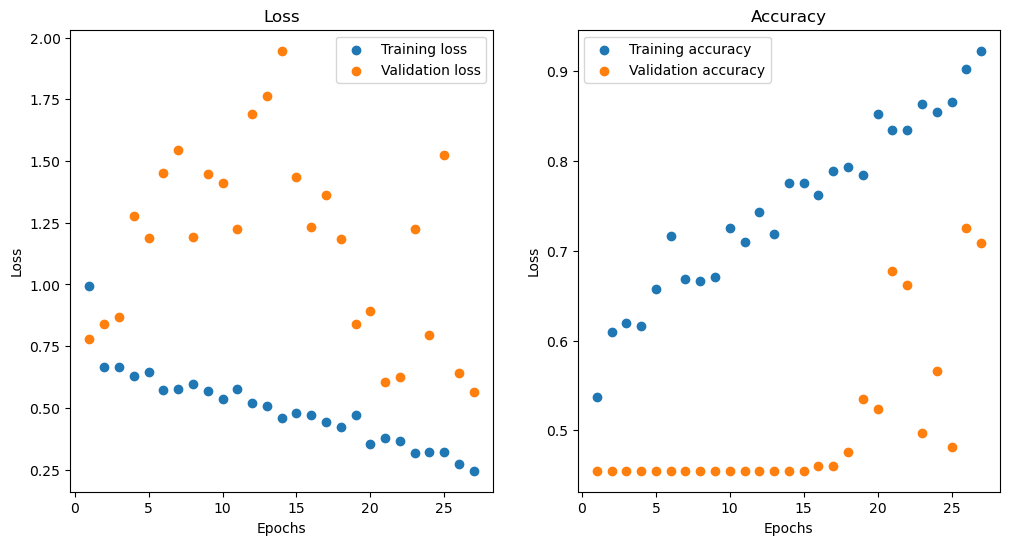

In [52]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
axs[0].set_title('Loss')
axs[0].scatter(epochs, loss, label = 'Training loss')
axs[0].scatter(epochs, val_loss, label = 'Validation loss')
axs[0].legend()
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
axs[1].set_title('Accuracy')
axs[1].scatter(epochs, accuracy, label = 'Training accuracy')
axs[1].scatter(epochs, val_accuracy, label = 'Validation accuracy')
axs[1].legend()
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')


plt.show()

6/6 [==============================] - 3s 543ms/step
[[73 30]
 [25 61]]


<AxesSubplot: >

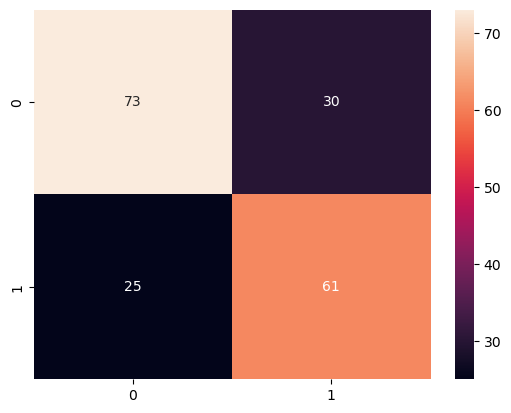

In [53]:
prediction_NN = cnn_model.predict(x_test)
prediction_NN = np.argmax(prediction_NN, axis=-1)

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, prediction_NN)
print(cm)
sns.heatmap(cm, annot=True)

In [54]:

#  RANDOM FOREST PART
#  Now, let us use features from convolutional network for RF
from sklearn.ensemble import RandomForestClassifier
RF_model = RandomForestClassifier(n_estimators = 50, random_state = 42)

X_for_RF = feature_extractor.predict(x_train) #This will be input to RF

# Train the model on training data
RF_model.fit(X_for_RF, y_train) #For sklearn no one hot encoding

#Send test data through same feature extractor process
X_test_feature = feature_extractor.predict(x_test)
#Now predict using the trained RF model. 
prediction_RF = RF_model.predict(X_test_feature)

#Print overall accuracy
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(y_test, prediction_RF))

6/6 [==============================] - 3s 543ms/step
Accuracy =  0.7566137566137566


[[84 19]
 [27 59]]


<AxesSubplot: >

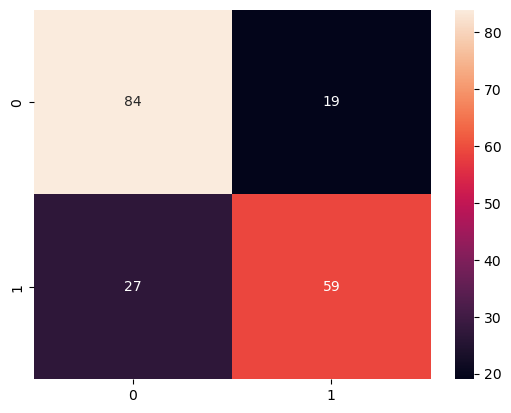

In [55]:
#Confusion Matrix - verify accuracy of each class
cm = confusion_matrix(y_test, prediction_RF)
print(cm)
sns.heatmap(cm, annot=True)

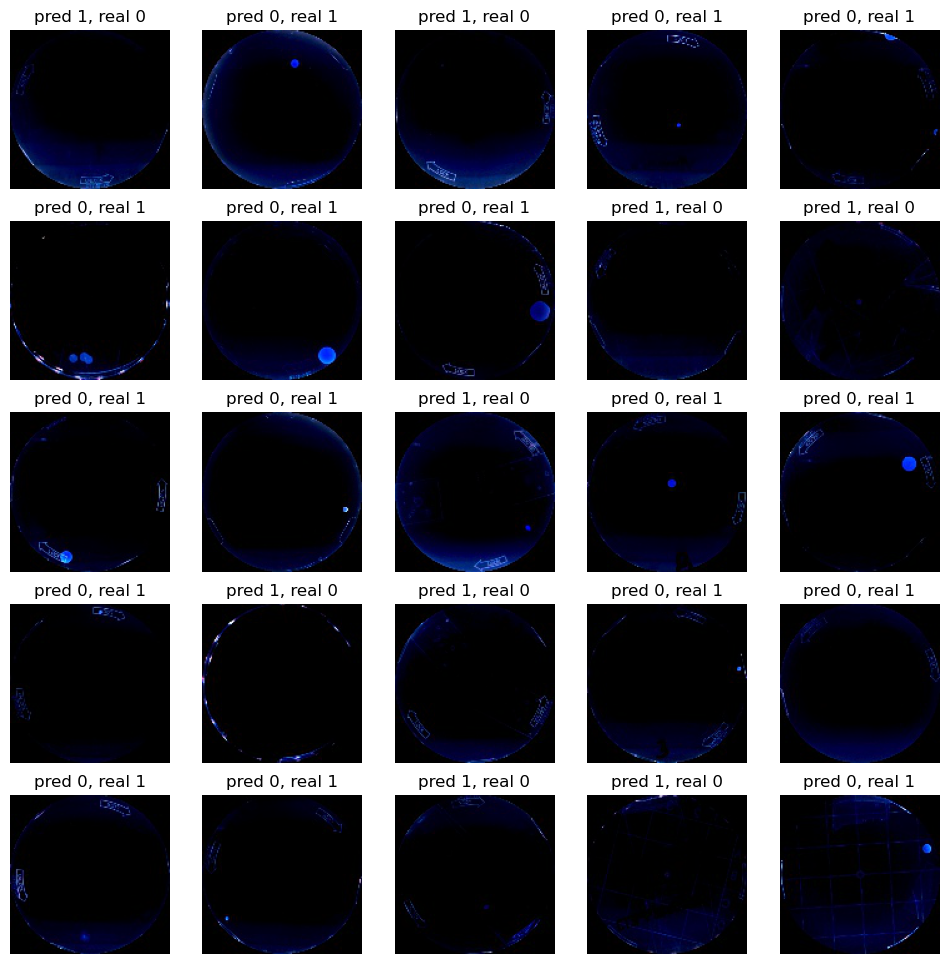

In [56]:
# Visualize 25 mistakes
error_idx = [i for i, rslt in enumerate(y_test) if (rslt + prediction_RF[i] == 1)]

fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(12,12))

for i, j in [(i,j) for i in np.arange(5) for j in np.arange(5)]:
    if (5*i+j) < len(error_idx):
        idx = error_idx[5*i+j]
        image = cv2.cvtColor(x_test[idx], cv2.COLOR_HSV2RGB)
        axs[i,j].imshow(image)
        axs[i,j].set_title(f'pred {int(prediction_RF[idx])}, real {int(y_test[idx])}')
        axs[i,j].axis('off')

plt.show()